# 어제 오른 내 주식, 과연 내일은?
## 프로젝트 : 주식 예측에 도전해 보자
### **학습 목표**

시계열 데이터의 특성과 안정적(Stationary) 시계열의 개념을 이해한다.

ARIMA 모델을 구성하는 AR, MA, Diffencing의 개념을 이해하고 간단한 시계열 데이터에 적용하자

실제 주식 데이터에 ARIMA를 적용해서 예측 정확도를 확인해 본다.

### STEP 1 : 시계열 데이터 준비
칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume

날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있다.

종가(Close)만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
# 데이터셋 가져오기
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath) 
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-05-18,47950.0,49100.0,47600.0,48800.0,46788.835938,20481981
1,2020-05-19,50100.0,50500.0,49700.0,50300.0,48227.015625,25168295
2,2020-05-20,50000.0,50200.0,49800.0,50000.0,47939.382813,14896899
3,2020-05-21,50300.0,50400.0,49850.0,49950.0,47891.437500,14949266
4,2020-05-22,49600.0,49800.0,48600.0,48750.0,46740.894531,19706284


판다스에는  Series와 DataFrame이라는 두 종류의 자료구조가 있다고 하는데 Series는 1차원 자료구조라고 함. DataFrame을 Series로 바꾸는거 보니 아마도 1차원이어야지 시계열 안정성을 분석할수 있어서 그런건가?

In [3]:
# DataFrame에서 Date 컬럼을 index로 삼아 시계열을 생성해 보자
# 이번에는 Date를 index_col로 지정해 주었습니다. 
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-05-18,47950.0,49100.0,47600.0,48800.0,46788.835938,20481981
2020-05-19,50100.0,50500.0,49700.0,50300.0,48227.015625,25168295
2020-05-20,50000.0,50200.0,49800.0,50000.0,47939.382813,14896899
2020-05-21,50300.0,50400.0,49850.0,49950.0,47891.437500,14949266
2020-05-22,49600.0,49800.0,48600.0,48750.0,46740.894531,19706284


In [4]:
# 시간 컬럼이 index가 되었지만 아직도 type은 DataFrame으로 나옵니다. 
# 우리가 찾는 시계열은 바로 여기 있습니다.
ts = df['Close']  # 우선은 데이터 확인용이니 time series 의 이니셜을 따서 'ts'라고 이름 붙여줍시다!
print(type(ts)) # <class 'pandas.core.series.Series'>
ts.head()

<class 'pandas.core.series.Series'>


Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

In [5]:
# 시계열 데이터 준비
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

### STEP 2 : 각종 전처리 수행

결측치 처리

로그 변환

결측치 처리하는 방법은 두 가지가 있는데 하나는 결측지가 있는 데이터를 모두 삭제하는것이고((drop)으로 삭제하는 방식)

다른 하나는 결측치 양옆의 값들을 이용해서 적절히 보간(interpolate)하여 대입하는 방식이 있는데 이번경우에는 시간을 index로 가지는 시계열 데이터이므로 삭제하는 것보다는 보간하는 방법을 선택해야 한다고 한다

ex) 2와 4 사이 데이터가 NaN이라면 이 값을 3으로 채우는 방식

보간(補間) : 기울 보 사이 간 : 사이를 기우는 방식, 수 의 함수의 형태는 알 수 없으나 몇 가지 에 대한 함숫값 가 알려져 있을 때 그 사이의 임의의 에 대한 함숫값을 추정하는 것.



결측치가 있는 데이터를 모두 삭제(drop)

결측치 양옆의 값들을 이용해서 적절히 보간(interpolate)하여 대입


In [6]:
# 결측치 처리
ts=ts.interpolate(method='time') # 보간 기준은 time으로 한다
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

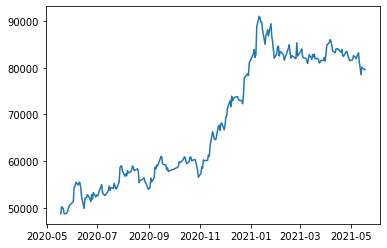

In [7]:
plt.plot(ts)

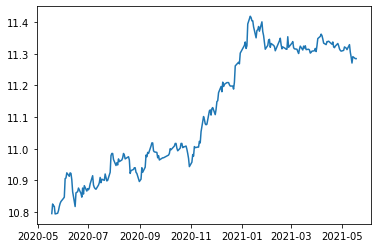

In [8]:
# 로그 변환
ts_log = np.log(ts)
plt.plot(ts_log)

### STEP 3 : 시계열 안정성 분석

정성적 그래프 분석

정량적 Augmented Dicky-Fuller Test

시계열 분해(Time Series Decomposition)

Residual 안정성 확인

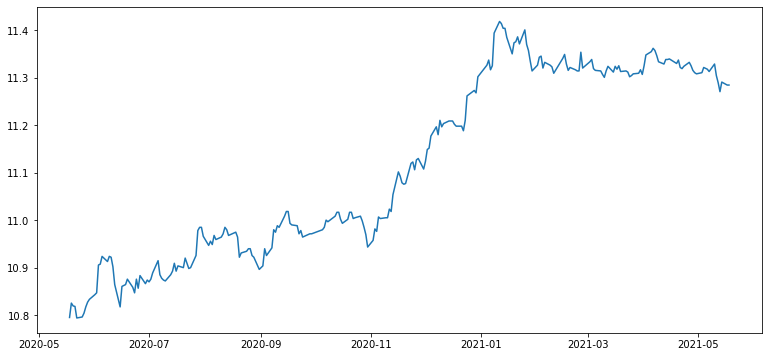

In [9]:
# 시각화를 통해 안정성(Stationarity) 여부를 확인해 보자
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6 

# 시계열(time series) 데이터를 차트로 그려 보자
plt.plot(ts_log)

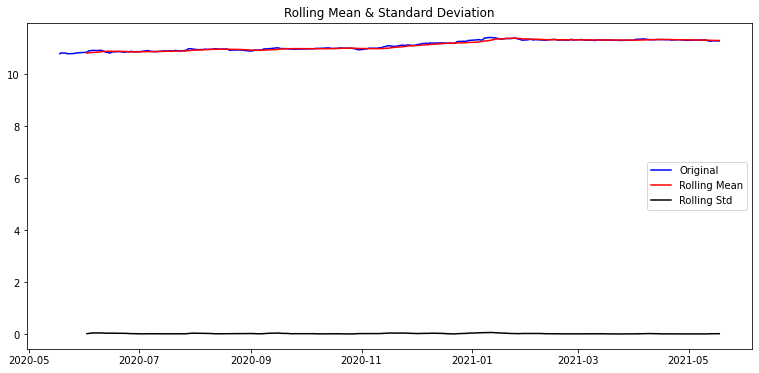

In [10]:
# 정석적 그래프 분석

# 일정 시간 내 구간 통계치(Rolling Statistics)를 시각화해 보는 함수
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
plot_rolling_statistics(ts_log, window=12)

In [11]:
# 정량적 Augmented Dicky-Fuller Test

# statsmodels 패키지에서 제공하는 adfuller 메서드를 이용해 주어진 
# timeseries에 대한 Augmented Dickey-Fuller Test를 수행하는 코드
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
# Augmented Dickey-Fuller Test를 수행해 봅시다.
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


LMS 예제에 있었던 Moving average 제거 - 추세(Trend) 상쇄하기,차분(Differencing) - 계절성(Seasonality) 상쇄하기를 statsmodels 라이브러리 안에있는 seasonal_decompose 메서드를 통해 시계열 안에 존재하는 trend, seasonality를 직접 분리해 낼 수 있다. 이 기능을 활용해서 직접 수행하지 않고도 훨씬 안정적으로 시계열을 분리해 낼 수 있다고 한다. 

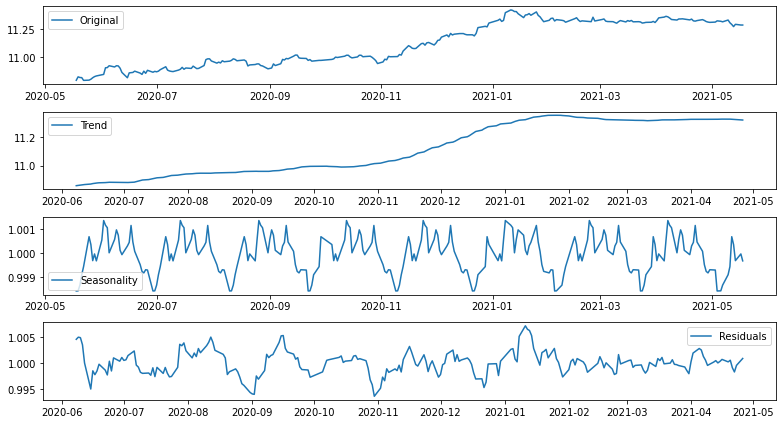

In [12]:
# 시계열 분해(Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

오류 떠서 무슨 일인가 했더니 LMS 예제 가보니 예시 코드에 decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 이부분이 추가 되어 있었음 예시 코드 대로 하니까 실행되었음

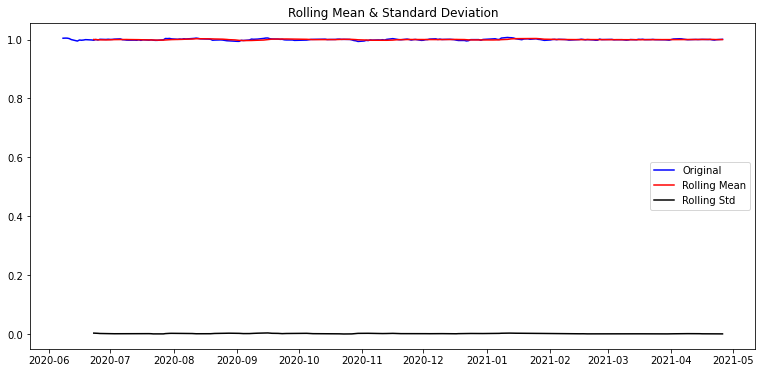

In [13]:
# Residual 안정성 확인
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [14]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


### STEP 4 : 학습, 테스트 데이터셋 생성

학습, 테스트 데이터셋 분리

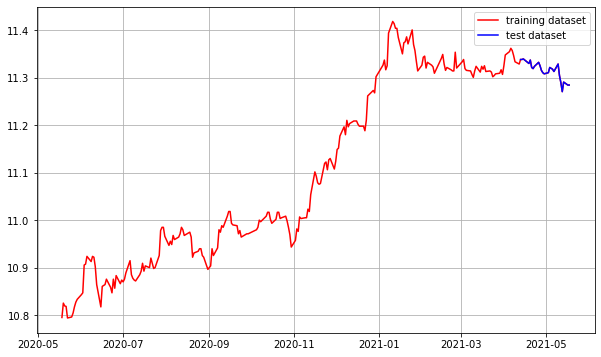

In [15]:
# 학습, 테스트 데이터셋 분리

train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### STEP 5 : 적정 ARIMA 모수 찾기

AR(자기회귀, Autoregressive) : 과거 값들에 대한 회귀로 미래 값을 예측하는 방법 , AR은 시계열의 Residual에 해당하는 부분을 모델링한다고 볼 수 있습니다.

I(차분 누적, Integration) : I는 시계열의 Seasonality에 해당하는 부분을 모델링한다고 볼 수 있습니다.

MA(이동평균, Moving Average) : MA는 시계열의 Trend에 해당하는 부분을 모델링한다고 볼 수 있습니다.

AR I MA 합쳐서 ARIMA

ACF, PACF 그려보기 -> p,q 구하기

차분 안정성 확인 -> d 구하기

ARIMA를 효과적으로 활용하기 위해서는 ARIMA의 모수(parameter)를 잘 설정해야 한다고 한다

ACF : 시차(lag)에 따른 관측치들 사이의 관련성을 측정하는 함수

PACF : 다른 관측치의 영향력을 배제하고 두 시차의 관측치 간 관련성을 측정하는 함수

p : 자기회귀 모형(AR)의 시차, q : 이동평균 모형(MA)의 시차,  d : 차분 누적(I) 횟수




/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


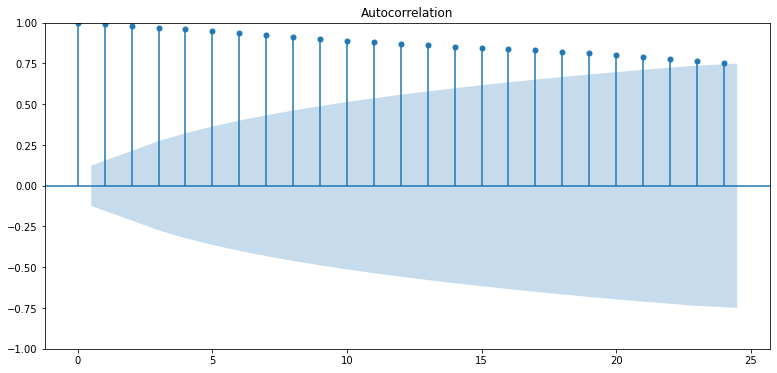

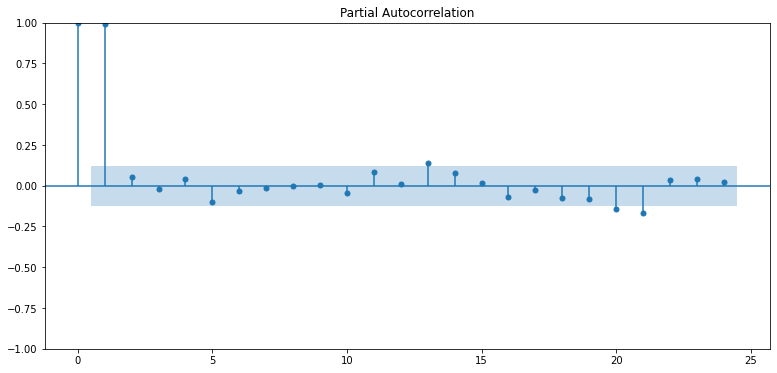

In [16]:
# ACF, PACF 그려보기 -> p,q 구하기

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


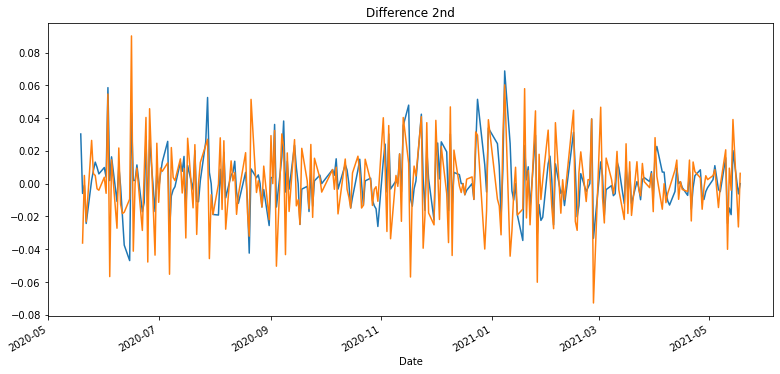

In [17]:
# 차분 안정성 확인 -> d 구하기

# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

### STEP 6 : ARIMA 모델 훈련과 테스트

ARIMA 모델 빌드와 훈련

모델 테스트 및 플로팅

최종 예측 모델 정확도 측정(MAPE)

In [18]:
# AARIMA 모델 빌드와 훈련

import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 0, 1)) # 모수는 이전 그래프를 참고 / order=(p, d, q) 순이라는건가?
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 583.361
Date:                Thu, 17 Feb 2022   AIC                          -1156.722
Time:                        06:51:56   BIC                          -1139.642
Sample:                             0   HQIC                         -1149.828
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.129     86.277      0.000      10.838      11.342
ar.L1          0.7739      1.821      0.425      0.671      -2.796       4.344
ar.L2          0.2191      1.811      0.121      0.9

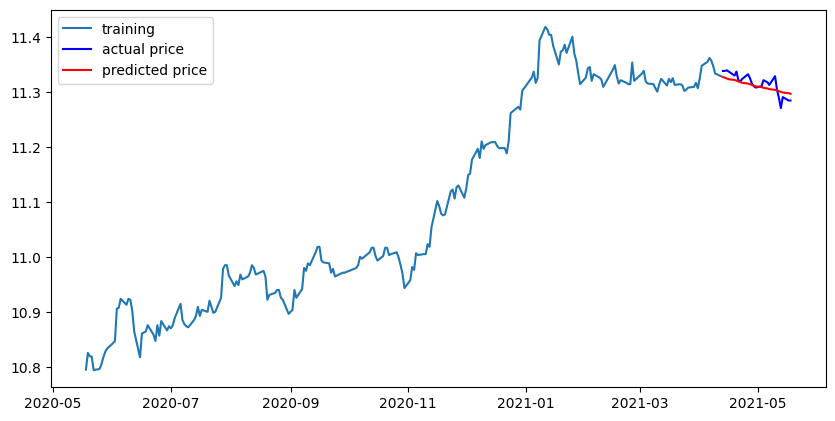

In [19]:
# 모델 테스트 및 플로팅

# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [20]:
# 최종 예측 모델 정확도 측정(MAPE)

# 시계열 데이터를 log로 변환했기 때문에 다시 exp로 변환해야 정확한 오차를 계산할수 있다고 한다
# np.exp()를 통해 전부 원본 스케일로 돌린 후 MSE, MAE, RMSE, MAPE를 계산한다
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc)) 
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1048973.6014239907
MAE:  843.7579531508708
RMSE:  1024.19412292006
MAPE: 1.03%


### STEP 7 : 다른 주식 종목 예측해 보기

In [21]:
# 데이터셋 가져오기

dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/COKE.csv'
df = pd.read_csv(dataset_filepath) 
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-02-16,275.109985,278.329987,272.130005,273.730011,273.055756,24200
1,2021-02-17,274.489990,279.890015,271.000000,271.769989,271.100586,39600
2,2021-02-18,270.220001,273.670013,268.149994,268.600006,267.938416,18400
3,2021-02-19,267.920013,269.549988,262.950012,264.880005,264.227570,28800
4,2021-02-22,263.000000,264.290009,255.050003,261.359985,260.716217,23300


In [22]:
# 시계열 데이터 준비

dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/COKE.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2021-02-16    273.730011
2021-02-17    271.769989
2021-02-18    268.600006
2021-02-19    264.880005
2021-02-22    261.359985
Name: Close, dtype: float64

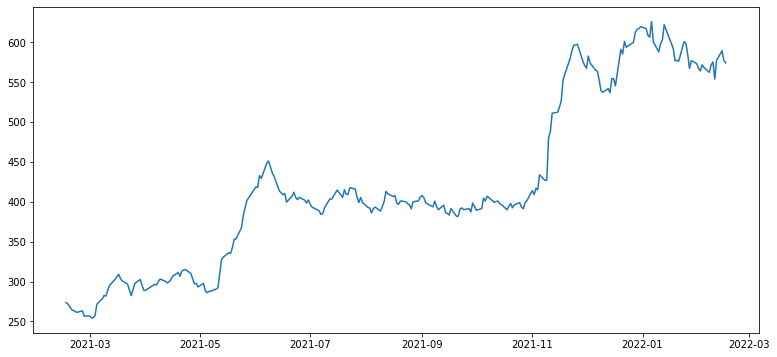

In [23]:
# 결측치 처리

ts=ts.interpolate(method='time')
ts[ts.isna()]
plt.plot(ts)

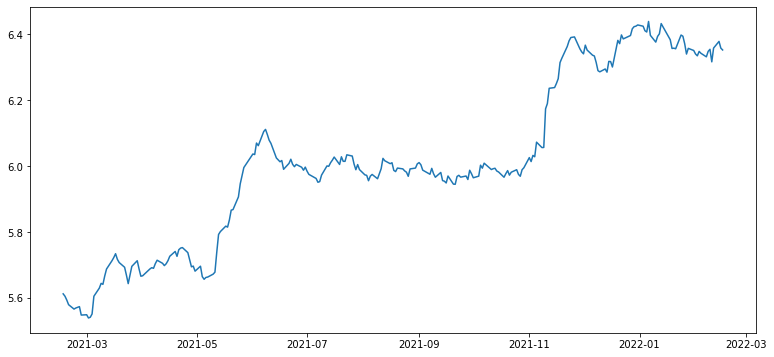

In [24]:
# 로그 변환

ts_log = np.log(ts)
plt.plot(ts_log)

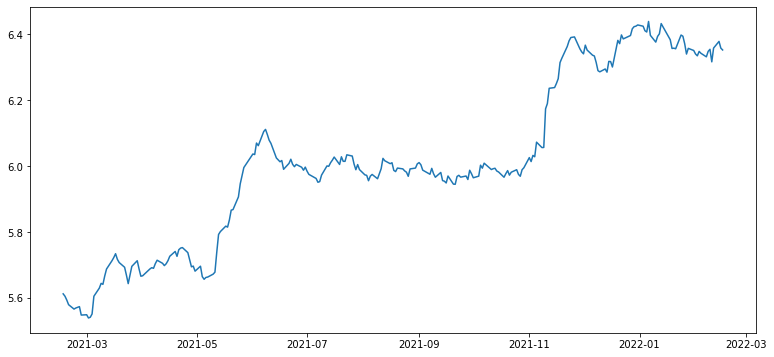

In [25]:
# 시각화를 통해 안정성(Stationarity) 여부를 확인해 보자

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6 

# 시계열(time series) 데이터를 차트로 그려 보자
plt.plot(ts_log)

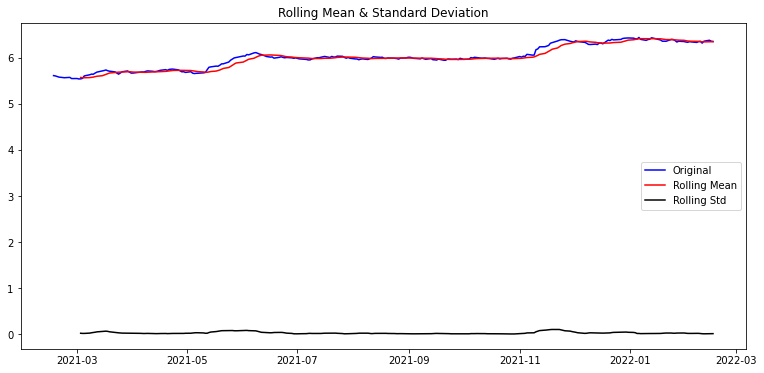

In [26]:
# 정석적 그래프 분석

# 일정 시간 내 구간 통계치(Rolling Statistics)를 시각화해 보는 함수
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
plot_rolling_statistics(ts_log, window=12)

In [27]:
# 정량적 Augmented Dicky-Fuller Test

# statsmodels 패키지에서 제공하는 adfuller 메서드를 이용해 주어진 
# timeseries에 대한 Augmented Dickey-Fuller Test를 수행하는 코드
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
# 그럼 이전 스텝에서 정성적으로 분석해 보았던 두 시계열(Time Series)에 대한 
# Augmented Dickey-Fuller Test를 수행해 봅시다.
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.269283
p-value                          0.643106
#Lags Used                       3.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


여기서 오류가 떴었음. 맥도날드 데이터를 불러왔으나 정상적 정량적까지는 되었으나 시계열 분해에서 오류가 뜨면서 되지않았다. 시각화로 안정성 여부와 정석적 그래프로 봤을때 음수가 지속되는걸 볼수있었는데 아마도 그원인으로 인해서 시계열 분해를 할때 오류가 난게 아닌가 확인된다. 오류를 찾아보니 0이나 음수이면 어쩌구 저쩌구 하면서 안된다 이런 오류인거로 확인했지만 정확하게는 알수없었고 일단 추측은 그렇게 하였다. 맥도날드 데이터로는 더이상 진행이 불가하여 새롭게 코카콜라 데이터로 진행해보았는데 아무문제 없이 제대로 실행이 되었다.

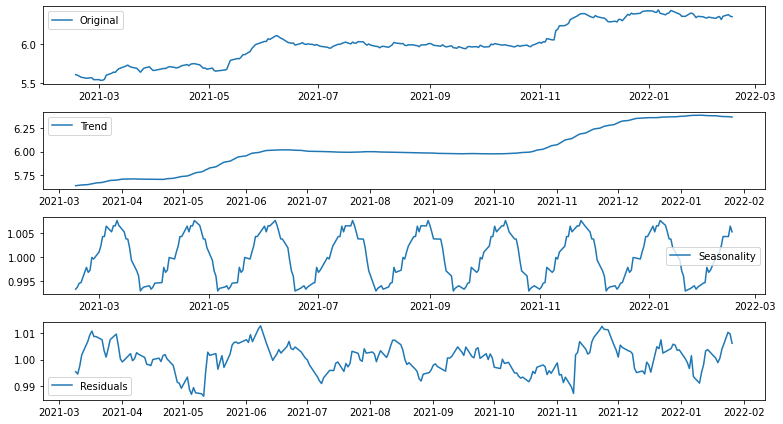

In [28]:
# 시계열 분해(Time Series Decomposition)

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

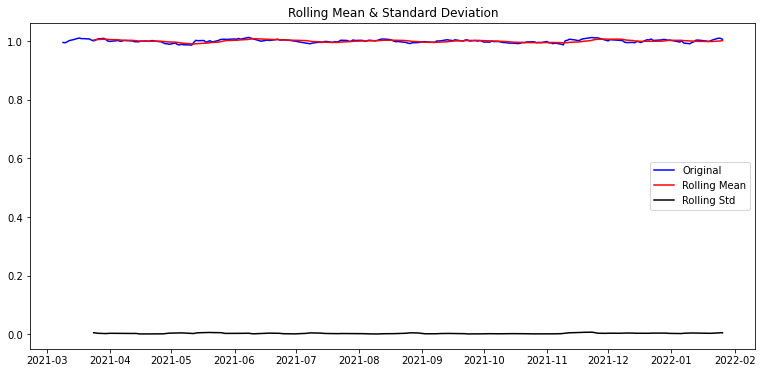

In [29]:
# Residual 안정성 확인
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [30]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -4.165984
p-value                          0.000752
#Lags Used                       0.000000
Number of Observations Used    224.000000
Critical Value (1%)             -3.459885
Critical Value (5%)             -2.874531
Critical Value (10%)            -2.573694
dtype: float64


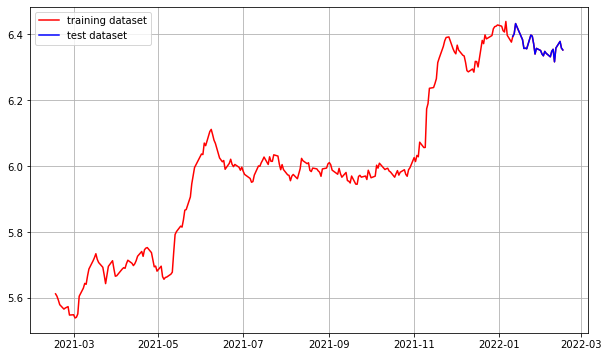

In [31]:
# 학습, 테스트 데이터셋 분리

train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

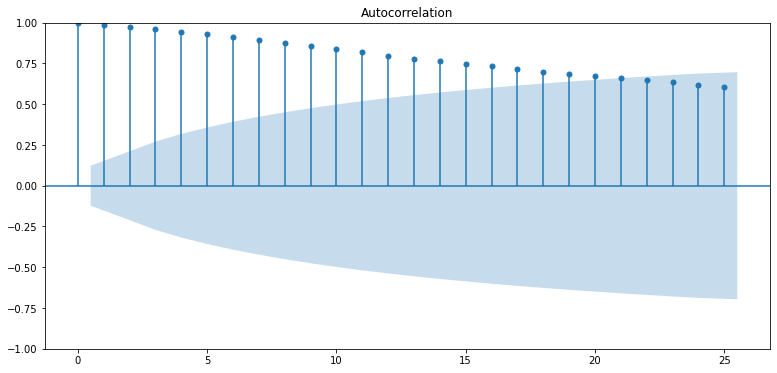

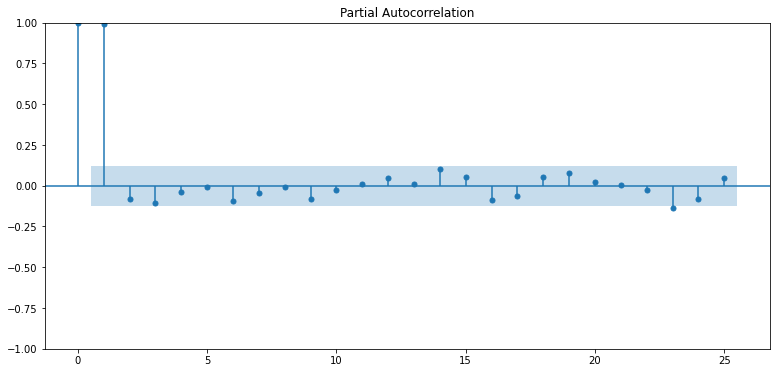

In [32]:
# ACF, PACF 그려보기 -> p,q 구하기

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -9.526757e+00
p-value                        2.963644e-16
#Lags Used                     1.000000e+00
Number of Observations Used    2.520000e+02
Critical Value (1%)           -3.456569e+00
Critical Value (5%)           -2.873079e+00
Critical Value (10%)          -2.572919e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.075683e+01
p-value                        2.580249e-19
#Lags Used                     5.000000e+00
Number of Observations Used    2.470000e+02
Critical Value (1%)           -3.457105e+00
Critical Value (5%)           -2.873314e+00
Critical Value (10%)          -2.573044e+00
dtype: float64


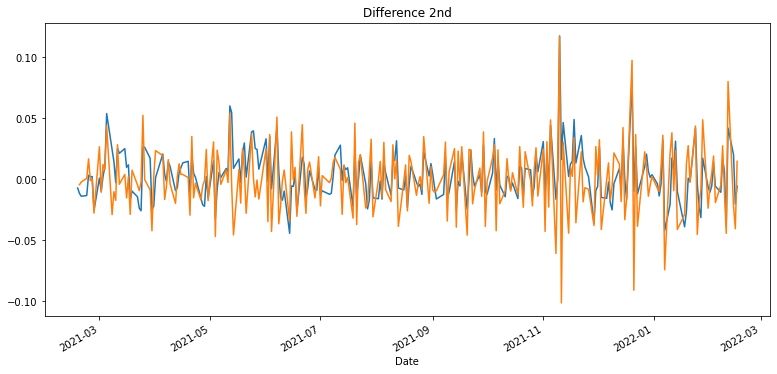

In [33]:
# 차분 안정성 확인 -> d 구하기

# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [34]:
# AARIMA 모델 빌드와 훈련

import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 0, 1)) # 모수는 이전 그래프를 참고 
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  229
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 562.895
Date:                Thu, 17 Feb 2022   AIC                          -1115.791
Time:                        06:51:59   BIC                          -1098.622
Sample:                             0   HQIC                         -1108.864
                                - 229                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.9926      0.319     18.773      0.000       5.367       6.618
ar.L1          0.0044      0.018      0.250      0.803      -0.030       0.039
ar.L2          0.9922      0.018     55.731      0.0

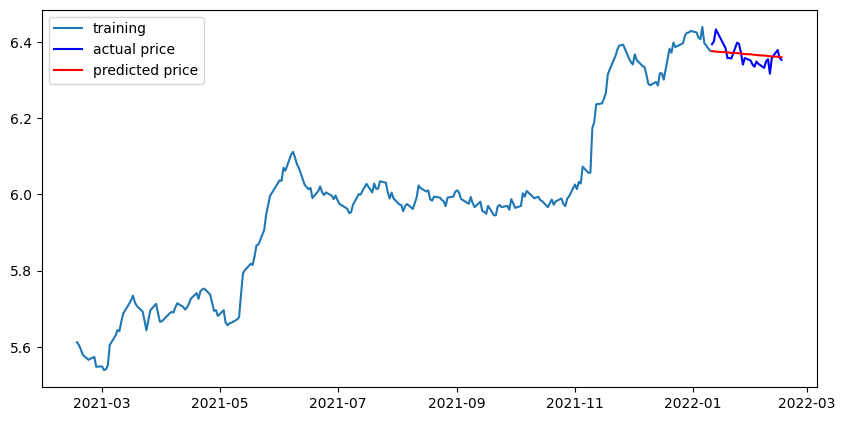

In [35]:
# 모델 테스트 및 플로팅

# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [36]:
# 최종 예측 모델 정확도 측정(MAPE)

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  217.4917542434079
MAE:  12.24098152792246
RMSE:  14.747601643772722
MAPE: 2.10%


### 다른 주식 종목 예측2

In [37]:
# 데이터셋 가져오기

dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/PEP.csv'
df = pd.read_csv(dataset_filepath) 
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-02-17,134.059998,135.070007,133.860001,134.460007,130.643066,3353000
1,2021-02-18,134.070007,135.699997,133.910004,135.369995,131.527206,3935200
2,2021-02-19,135.009995,135.119995,132.289993,132.509995,128.748383,5414900
3,2021-02-22,132.039993,132.600006,130.759995,131.990005,128.243179,5792900
4,2021-02-23,132.649994,134.339996,131.300003,132.779999,129.010727,6264300


In [38]:
# 시계열 데이터 준비

dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/PEP.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2021-02-17    134.460007
2021-02-18    135.369995
2021-02-19    132.509995
2021-02-22    131.990005
2021-02-23    132.779999
Name: Close, dtype: float64

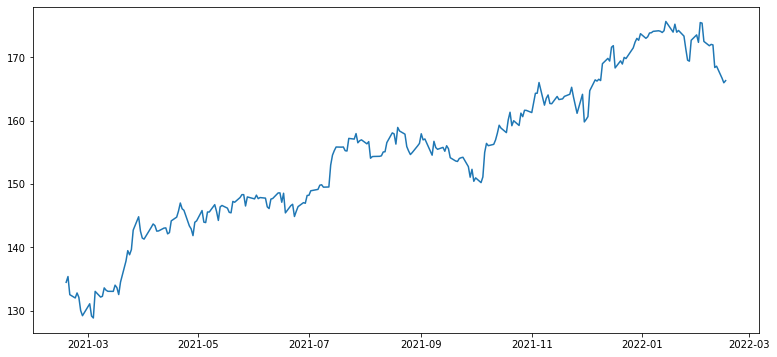

In [39]:
# 결측치 처리

ts=ts.interpolate(method='time')
ts[ts.isna()]
plt.plot(ts)

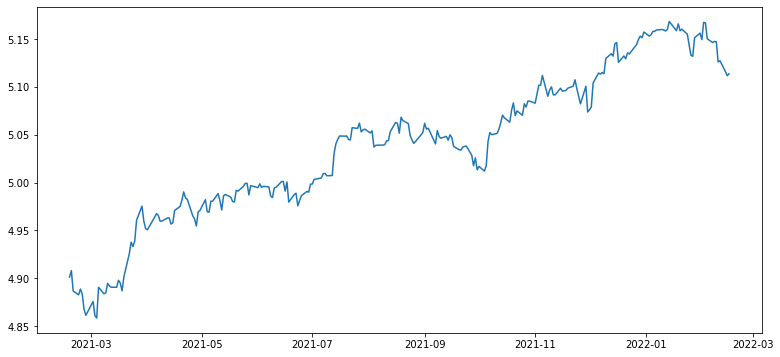

In [40]:
# 로그 변환

ts_log = np.log(ts)
plt.plot(ts_log)

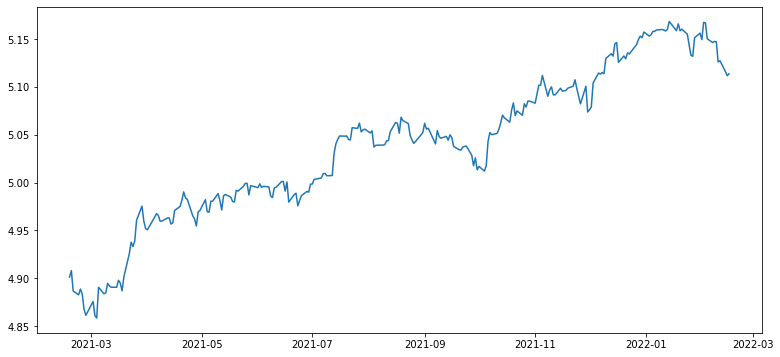

In [41]:
# 시각화를 통해 안정성(Stationarity) 여부를 확인해 보자

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6 

# 시계열(time series) 데이터를 차트로 그려 보자
plt.plot(ts_log)

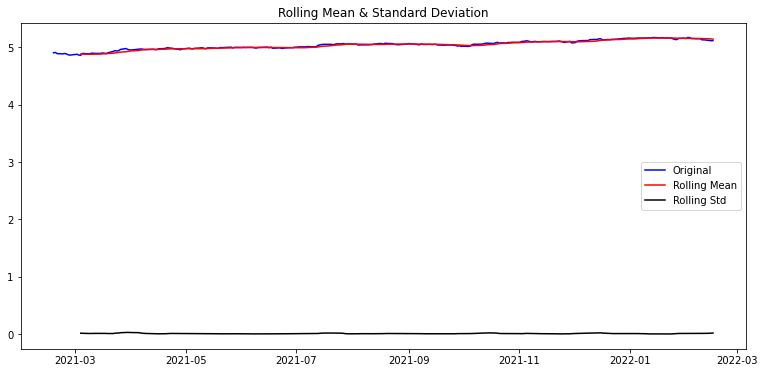

In [42]:
# 정석적 그래프 분석

# 일정 시간 내 구간 통계치(Rolling Statistics)를 시각화해 보는 함수
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
plot_rolling_statistics(ts_log, window=12)

In [43]:
# 정량적 Augmented Dicky-Fuller Test

# statsmodels 패키지에서 제공하는 adfuller 메서드를 이용해 주어진 
# timeseries에 대한 Augmented Dickey-Fuller Test를 수행하는 코드
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
# 그럼 이전 스텝에서 정성적으로 분석해 보았던 두 시계열(Time Series)에 대한 
# Augmented Dickey-Fuller Test를 수행해 봅시다.
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.479279
p-value                          0.543736
#Lags Used                       0.000000
Number of Observations Used    253.000000
Critical Value (1%)             -3.456464
Critical Value (5%)             -2.873033
Critical Value (10%)            -2.572895
dtype: float64


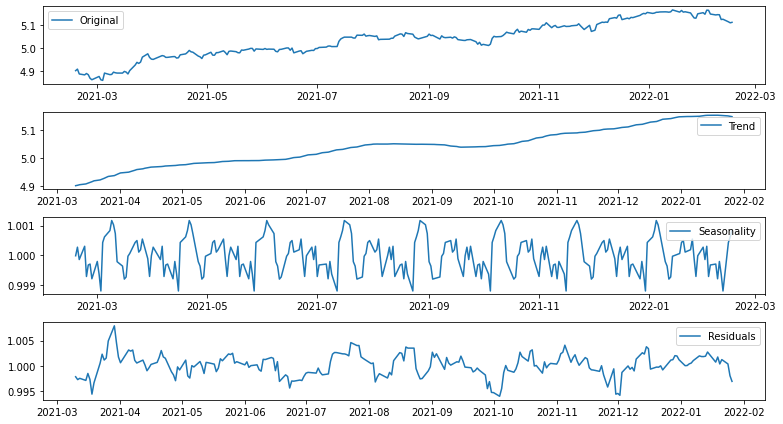

In [44]:
# 시계열 분해(Time Series Decomposition)

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

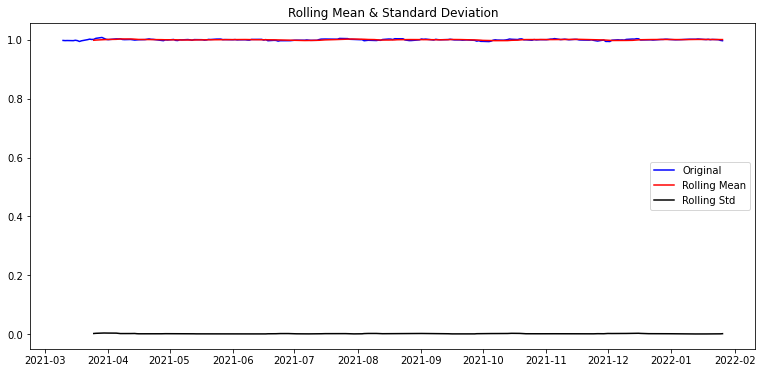

In [45]:
# Residual 안정성 확인
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [46]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.479704
p-value                          0.000002
#Lags Used                       0.000000
Number of Observations Used    223.000000
Critical Value (1%)             -3.460019
Critical Value (5%)             -2.874590
Critical Value (10%)            -2.573725
dtype: float64


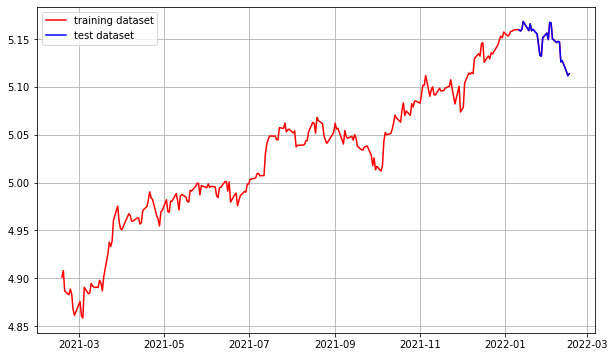

In [47]:
# 학습, 테스트 데이터셋 분리

train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

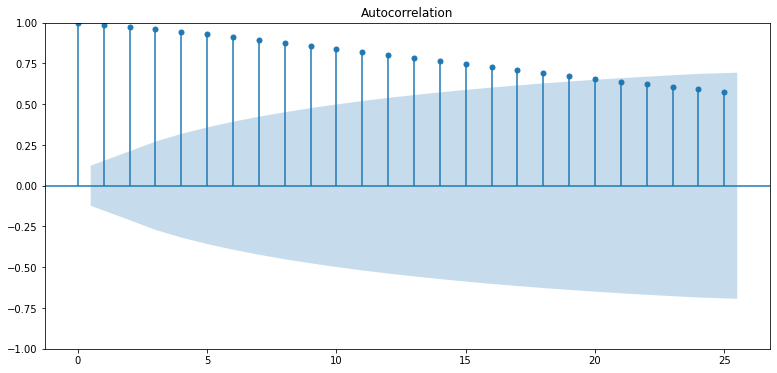

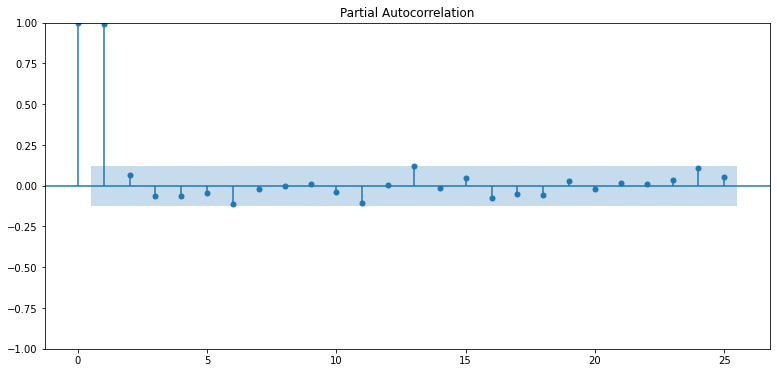

In [48]:
# ACF, PACF 그려보기 -> p,q 구하기

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.712070e+01
p-value                        7.259868e-30
#Lags Used                     0.000000e+00
Number of Observations Used    2.520000e+02
Critical Value (1%)           -3.456569e+00
Critical Value (5%)           -2.873079e+00
Critical Value (10%)          -2.572919e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -8.501581e+00
p-value                        1.234191e-13
#Lags Used                     1.300000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


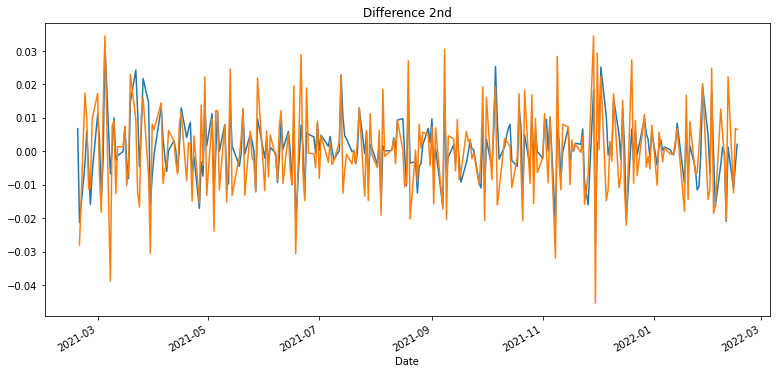

In [49]:
# 차분 안정성 확인 -> d 구하기

# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [50]:
# AARIMA 모델 빌드와 훈련

import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 0, 1)) # 모수는 이전 그래프를 참고 
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  228
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 749.571
Date:                Thu, 17 Feb 2022   AIC                          -1489.143
Time:                        06:52:02   BIC                          -1471.996
Sample:                             0   HQIC                         -1482.225
                                - 228                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0278      0.025    203.467      0.000       4.979       5.076
ar.L1          1.9342      0.086     22.485      0.000       1.766       2.103
ar.L2         -0.9363      0.084    -11.093      0.0

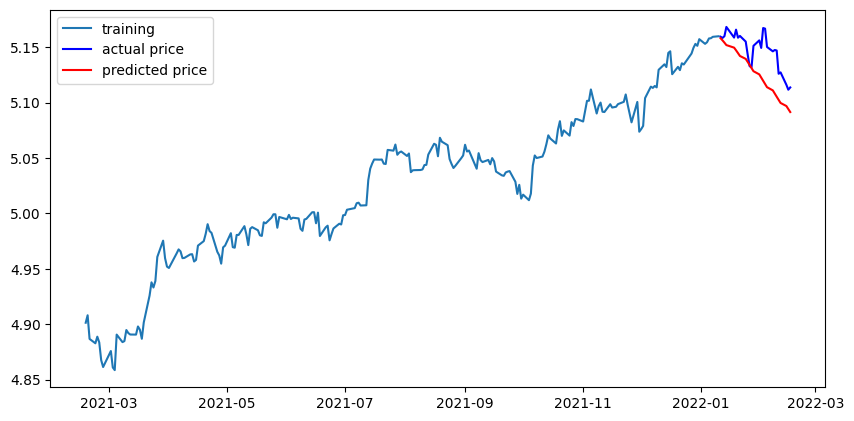

In [51]:
# 모델 테스트 및 플로팅

# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [52]:
# 최종 예측 모델 정확도 측정(MAPE)

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  18.643160314040344
MAE:  3.5919274389220552
RMSE:  4.317772610274925
MAPE: 2.09%


### 다른 주식 종목 예측3

In [53]:
# 데이터셋 가져오기

dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/MNST.csv'
df = pd.read_csv(dataset_filepath) 
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-02-17,92.000000,92.389999,91.459999,92.160004,92.160004,1202100
1,2021-02-18,91.470001,92.949997,91.000000,92.650002,92.650002,1310800
2,2021-02-19,92.339996,92.500000,89.379997,89.650002,89.650002,2303200
3,2021-02-22,89.570000,89.959999,88.800003,89.169998,89.169998,2191100
4,2021-02-23,89.519997,89.550003,86.440002,88.320000,88.320000,2720500


In [54]:
# 시계열 데이터 준비

dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/MNST.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2021-02-17    92.160004
2021-02-18    92.650002
2021-02-19    89.650002
2021-02-22    89.169998
2021-02-23    88.320000
Name: Close, dtype: float64

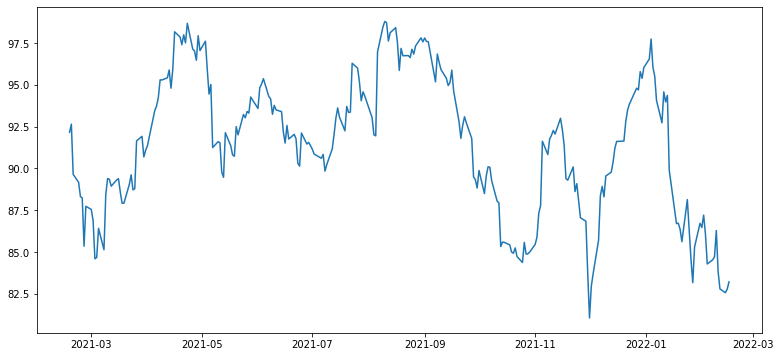

In [55]:
# 결측치 처리

ts=ts.interpolate(method='time')
ts[ts.isna()]
plt.plot(ts)

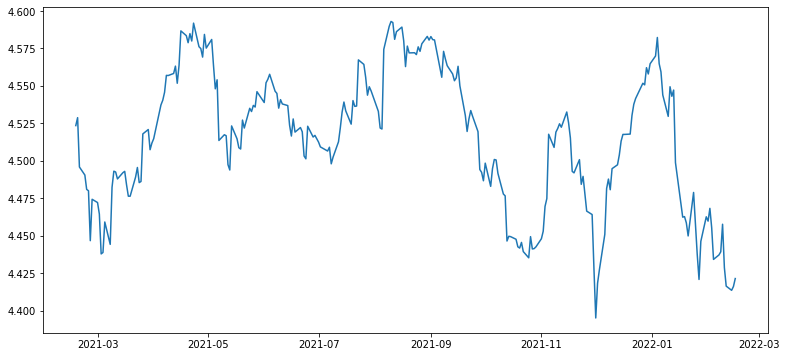

In [56]:
# 로그 변환

ts_log = np.log(ts)
plt.plot(ts_log)

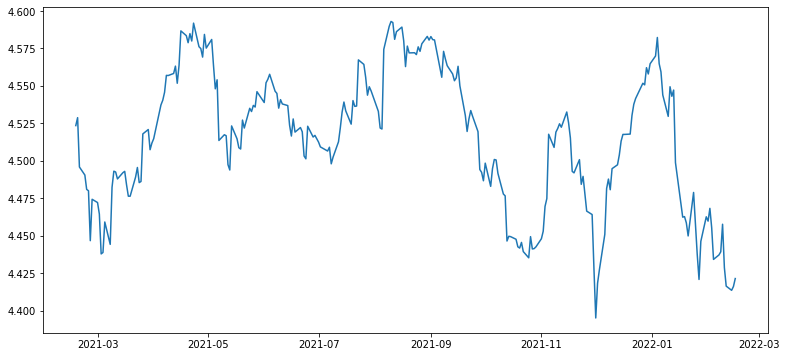

In [57]:
# 시각화를 통해 안정성(Stationarity) 여부를 확인해 보자

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6 

# 시계열(time series) 데이터를 차트로 그려 보자
plt.plot(ts_log)

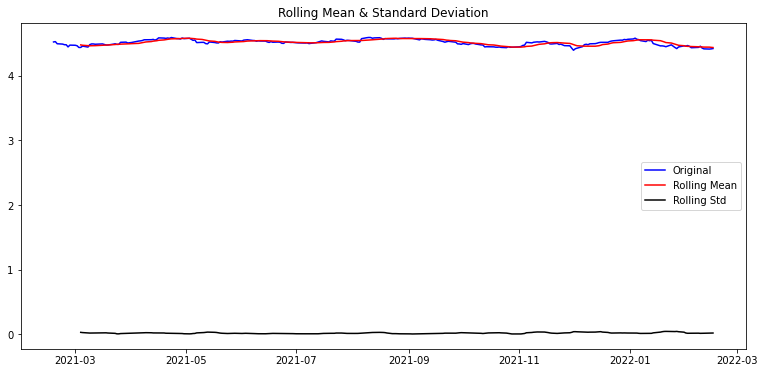

In [58]:
# 정석적 그래프 분석

# 일정 시간 내 구간 통계치(Rolling Statistics)를 시각화해 보는 함수
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
plot_rolling_statistics(ts_log, window=12)

In [59]:
# 정량적 Augmented Dicky-Fuller Test

# statsmodels 패키지에서 제공하는 adfuller 메서드를 이용해 주어진 
# timeseries에 대한 Augmented Dickey-Fuller Test를 수행하는 코드
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
# 그럼 이전 스텝에서 정성적으로 분석해 보았던 두 시계열(Time Series)에 대한 
# Augmented Dickey-Fuller Test를 수행해 봅시다.
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.943385
p-value                          0.311935
#Lags Used                       0.000000
Number of Observations Used    253.000000
Critical Value (1%)             -3.456464
Critical Value (5%)             -2.873033
Critical Value (10%)            -2.572895
dtype: float64


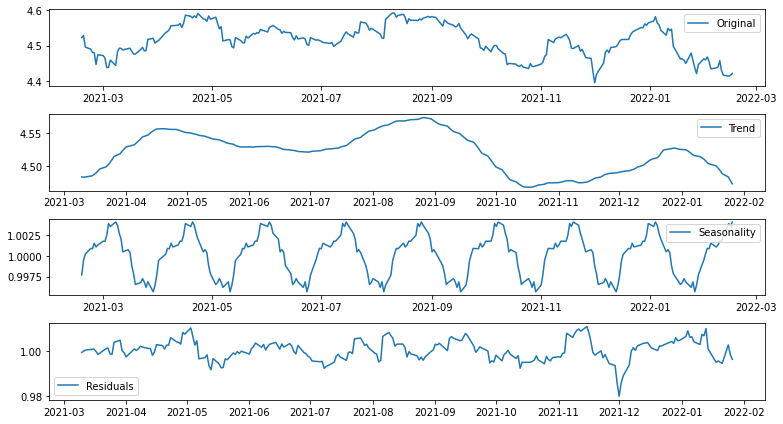

In [60]:
# 시계열 분해(Time Series Decomposition)

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

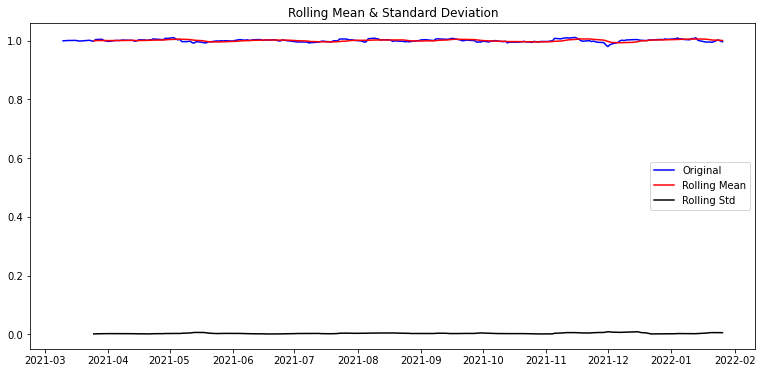

In [61]:
# Residual 안정성 확인
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [62]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.167800
p-value                          0.000010
#Lags Used                       7.000000
Number of Observations Used    216.000000
Critical Value (1%)             -3.460992
Critical Value (5%)             -2.875016
Critical Value (10%)            -2.573952
dtype: float64


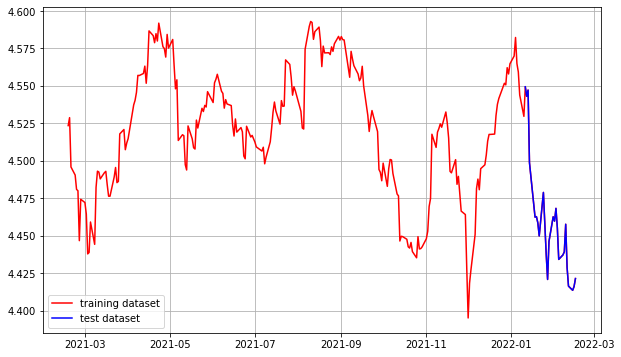

In [63]:
# 학습, 테스트 데이터셋 분리

train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

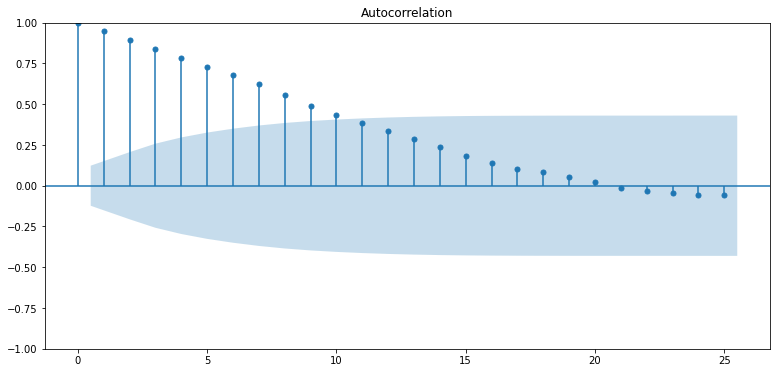

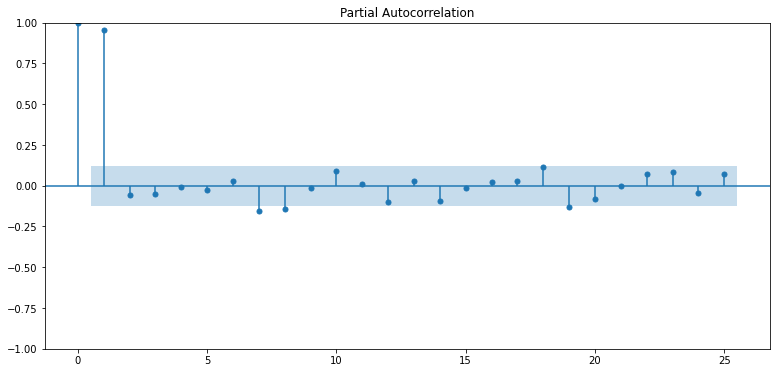

In [64]:
# ACF, PACF 그려보기 -> p,q 구하기

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.549151e+01
p-value                        2.481376e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.520000e+02
Critical Value (1%)           -3.456569e+00
Critical Value (5%)           -2.873079e+00
Critical Value (10%)          -2.572919e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.226267e+01
p-value                        9.005013e-23
#Lags Used                     5.000000e+00
Number of Observations Used    2.460000e+02
Critical Value (1%)           -3.457215e+00
Critical Value (5%)           -2.873362e+00
Critical Value (10%)          -2.573070e+00
dtype: float64


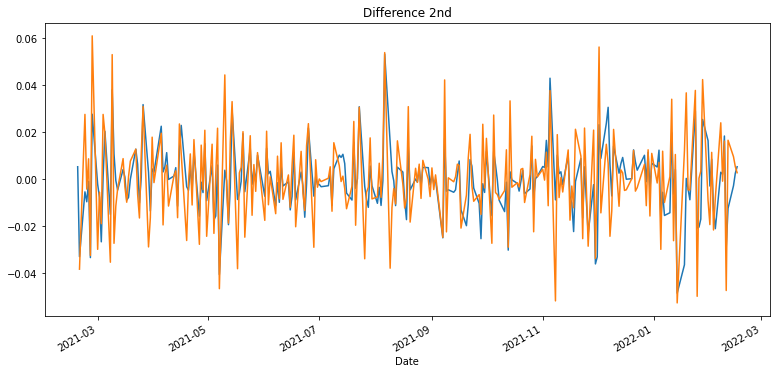

In [65]:
# 차분 안정성 확인 -> d 구하기

# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [66]:
# AARIMA 모델 빌드와 훈련

import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 0, 1)) # 모수는 이전 그래프를 참고 
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  228
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 670.676
Date:                Thu, 17 Feb 2022   AIC                          -1331.351
Time:                        06:52:05   BIC                          -1314.204
Sample:                             0   HQIC                         -1324.433
                                - 228                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.5217      0.018    244.453      0.000       4.485       4.558
ar.L1          0.2176      1.006      0.216      0.829      -1.755       2.190
ar.L2          0.6980      0.946      0.738      0.4

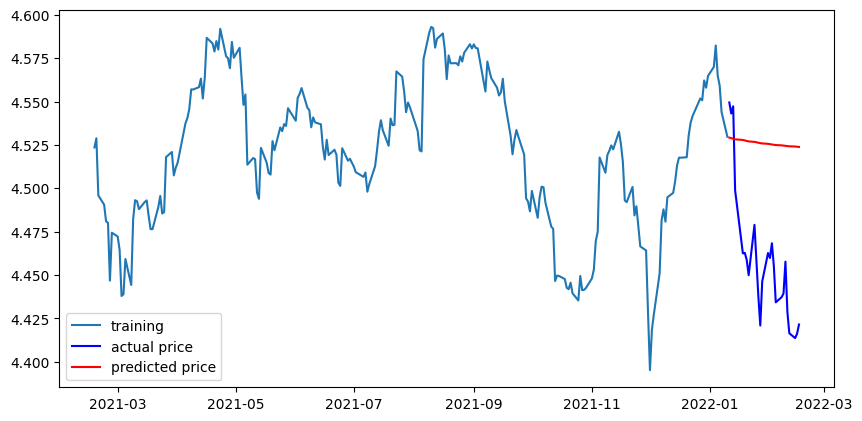

In [67]:
# 모델 테스트 및 플로팅

# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [68]:
# 최종 예측 모델 정확도 측정(MAPE)

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  45.72963671355262
MAE:  6.336788889901012
RMSE:  6.762369164246553
MAPE: 7.44%


## 회고

통계학적인거라 그런가 잘 봐도 잘 이해가 되지 않았다. 모수는 일단 예제에 있는대로 했는데 잘나온거같긴해서 따로 만져보지 않았고 모수에 대한 개념을 먼저 익혀야 할거같은데 봐도 잘 모르겠음. 3개 종목 이상 MAPE는 15% 미만의 정확도로 예측 되었지만 이부분에 대해서도 잘 이해는 되지 않았고 일단 노드에 있는대로 따라했더니 잘나와서 다행인것 같다. 그리고 다른 주식들이랑 맥도날드랑 떨어지는폭이 큰 차이는 없는거 같은데 왜 안나왔는지는 의문이 든다. 주식도 잘 모르고 통계도 잘 몰라서 이유를 알수없음

